In [3]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image, ImageOps
import numpy as np
import scipy.misc
from six.moves import urllib
from styletransfer import Model, image_process
import matplotlib.pyplot as plt
%matplotlib inline  

Download VGG19

In [5]:
VGG_MODEL = 'imagenet-vgg-verydeep-19.mat' 
link = 'http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat'
if os.path.exists(VGG_MODEL):
    print("VGG-19 pre-trained model ready")
else:
    print("Downloading the VGG pre-trained model. This might take a while ...")
    file_name, _ = urllib.request.urlretrieve(link, VGG_MODEL)
    print('Successfully downloaded VGG-19 pre-trained model', VGG_MODEL)

VGG-19 pre-trained model ready


In [3]:
style_layers_choices = {1: ['conv1_1'],
                2: ['conv1_1', 'conv2_1'],
                3: ['conv1_1', 'conv2_1', 'conv3_1'],
                4: ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1'],
                5: ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']}
# give more weights to deeper layers.
W = [0.5, 1.0, 1.5, 3.0, 4.0]

content_layer = 'conv4_2'
style_layers = style_layers_choices[5]

# From paper "Very Deep Convolutional Networks for Large-Scale Image Recognition" 
# The input images should be zero-centered by mean pixel (rather than mean image) subtraction.
mean_pixels = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 

In [4]:
def gram_matrix(F, N, M):
    """
    Return the gram matrix for tensor F
    """
    F = tf.reshape(F, (M, N))
    return tf.matmul(tf.transpose(F), F)

def single_style_loss(a, g):
    """
    Calculate the style loss at a certain layer
    """
    N = a.shape[3]
    M = a.shape[1] * a.shape[2] 
    A = gram_matrix(a, N, M)
    G = gram_matrix(g, N, M)
    return tf.reduce_sum((G - A) ** 2 / ((2 * N * M) ** 2))

def total_style_loss(A, model):
    """
    Calculate total style loss
    """
    n_layers = len(style_layers)
    E = [single_style_loss(A[i], model[style_layers[i]]) for i in range(n_layers)]
    return sum([W[i] * E[i] for i in range(n_layers)])

def make_dir(path):
    """
    Create a directory
    """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [5]:
def losses(model, input_image, content_image, style_image, alpha, beta):
    """
    Create the total loss
    """
    with tf.variable_scope('loss') as scope:
        with tf.Session() as sess:
            sess.run(input_image.assign(content_image)) # assign content image to the input variable
            p = sess.run(model[content_layer])
            f = model[content_layer]
        content_loss = tf.reduce_sum((f - p) ** 2) / (4.0 * p.size)

        with tf.Session() as sess:
            sess.run(input_image.assign(style_image))
            A = sess.run([model[layer_name] for layer_name in style_layers])                              
        style_loss = total_style_loss(A, model)
    
        total_loss = alpha * content_loss + beta * style_loss
        
    return content_loss, style_loss, total_loss

In [10]:
def train(model, generated_image, initial_image, iter_num, name):
    loss = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(generated_image.assign(initial_image))
        initial_step = model['global_step'].eval()
        
        for i in range(initial_step, iter_num):
            sess.run(model['optimizer'])
            if (i + 1) % 100 == 0:
                gen_image, total_loss= sess.run([generated_image, model['total_loss']])
                gen_image = gen_image + mean_pixels
                
                print('Iter: {}  Loss: {:5.1f}'.format(i + 1, total_loss))
                loss.append(total_loss)

                if (i + 1) % 200 == 0:
                    filename = 'outputs/{}_{}.png'.format(name, i+1)
                    image_process.save_image(filename, gen_image)

    x = [100 * i for i in range(iter_num // 100)] 
    plt.plot(x, loss)
    plt.ylabel('Loss')
    plt.xlabel('Iterations')
    plt.show()

In [11]:
def train_model(content_name, style_name, alpha = 0.01, beta = 1, iter_num = 3000, 
                height= 250, width = 333, noise = 0.6, learning_rate = 2.0):
    STYLE_image = 'styles/' + style_name + '.jpg'
    CONTENT_image = 'content/' + content_name + '.jpg'
    with tf.variable_scope('input') as scope:
            input_image = tf.Variable(np.zeros([1, height, width, 3]), dtype=tf.float32)

    # make_dir('checkpoints')   
    make_dir('outputs')
    model = Model.build_vgg(VGG_MODEL, input_image)
    model['global_step'] = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

    content_image = image_process.get_resized_image(CONTENT_image, height, width)
    content_image = content_image - mean_pixels
    style_image = image_process.get_resized_image(STYLE_image, height, width)
    style_image = style_image - mean_pixels

    model['content_loss'], model['style_loss'], model['total_loss'] = losses(model, 
                                                    input_image, content_image, style_image, alpha, beta)

    model['optimizer'] = tf.train.AdamOptimizer(learning_rate).minimize(model['total_loss'], 
                                                            global_step=model['global_step'])

    initial_image = image_process.generate_noise_image(content_image, height, width, noise)
    name = content_name + '_' + style_name
    train(model, input_image, initial_image, iter_num, name)

Iter: 100
   Loss: 89561960.0
Iter: 200
   Loss: 39824108.0
Iter: 300
   Loss: 24379996.0
Iter: 400
   Loss: 17315404.0
Iter: 500
   Loss: 13270545.0
Iter: 600
   Loss: 10559899.0
Iter: 700
   Loss: 8951296.0
Iter: 800
   Loss: 8327781.0
Iter: 900
   Loss: 7116039.5
Iter: 1000
   Loss: 6255075.5
Iter: 1100
   Loss: 5705067.5
Iter: 1200
   Loss: 5303728.0
Iter: 1300
   Loss: 4946403.5
Iter: 1400
   Loss: 4622786.0
Iter: 1500
   Loss: 4374765.5
Iter: 1600
   Loss: 4167534.8
Iter: 1700
   Loss: 3948766.0
Iter: 1800
   Loss: 6256628.5
Iter: 1900
   Loss: 3768133.0
Iter: 2000
   Loss: 3528622.8
Iter: 2100
   Loss: 3392268.8
Iter: 2200
   Loss: 3267784.0
Iter: 2300
   Loss: 3230348.0
Iter: 2400
   Loss: 3581844.2
Iter: 2500
   Loss: 3042142.2
Iter: 2600
   Loss: 3149068.5
Iter: 2700
   Loss: 2849835.0
Iter: 2800
   Loss: 2790297.0
Iter: 2900
   Loss: 2955832.5
Iter: 3000
   Loss: 2789020.8


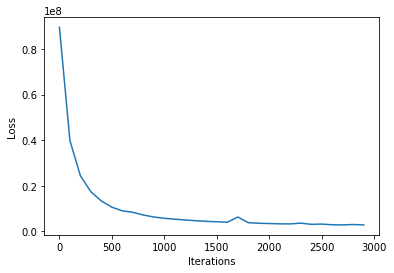

In [9]:
style_name = ['guernica']
content_name = ['deadpool']

for s_name in style_name:
    for c_name in content_name:
        train_model(c_name, s_name)
